In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import f_oneway, kruskal
from scipy.stats import chi2_contingency
from scipy.stats import skew, kurtosis
from statsmodels.graphics.gofplots import qqplot


import re
import string
import emoji
from bs4 import BeautifulSoup
from textblob import TextBlob

import nltk
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')


from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
import distance
from fuzzywuzzy import fuzz


import time
from tqdm.notebook import tqdm
tqdm.pandas()


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE


import xgboost as xgb
import lightgbm as lgbv

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/admin/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Loading Data & Initial Sanity Checks**

In [11]:
train_non_nlp_df = pd.read_csv('./data_post_feat_eng_fulldata/train_non_nlp.csv')
test_non_nlp_df = pd.read_csv('./data_post_feat_eng_fulldata/test_non_nlp.csv')

train_nlp_basic_df = pd.read_csv('./data_post_feat_eng_fulldata/train_nlp_basic.csv')
test_nlp_basic_df = pd.read_csv('./data_post_feat_eng_fulldata/test_nlp_basic.csv')

train_nlp_w2v_df = pd.read_csv('./data_post_feat_eng_fulldata/train_nlp_w2v.csv')
test_nlp_w2v_df = pd.read_csv('./data_post_feat_eng_fulldata/test_nlp_w2v.csv')

train_final_df = pd.read_csv('./data_post_feat_eng_fulldata/train_final.csv')
test_final_df = pd.read_csv('./data_post_feat_eng_fulldata/test_final.csv')

In [12]:
train_non_nlp_nlp_basic = pd.merge(train_non_nlp_df, train_nlp_basic_df, on='id', how='inner')
test_non_nlp_nlp_basic = pd.merge(test_non_nlp_df, test_nlp_basic_df, on='id', how='inner')

In [13]:
print(train_non_nlp_df.shape, test_non_nlp_df.shape)
print(train_nlp_basic_df.shape, test_nlp_basic_df.shape)
print(train_non_nlp_nlp_basic.shape, test_non_nlp_nlp_basic.shape)
print(train_nlp_w2v_df.shape, test_nlp_w2v_df.shape)
print(train_final_df.shape, test_final_df.shape)

(76471, 51) (32774, 51)
(76473, 62) (32775, 62)
(76471, 112) (32774, 112)
(76473, 409) (32775, 409)
(76471, 520) (32774, 520)


In [14]:
print(train_non_nlp_df.duplicated().sum())
print(test_non_nlp_df.duplicated().sum())

print(train_nlp_basic_df.duplicated().sum())
print(test_nlp_basic_df.duplicated().sum())

print(train_non_nlp_nlp_basic.duplicated().sum())
print(test_non_nlp_nlp_basic.duplicated().sum())

print(train_nlp_w2v_df.duplicated().sum())
print(test_nlp_w2v_df.duplicated().sum())

print(train_final_df.duplicated().sum())
print(test_final_df.duplicated().sum())

0
0
0
0
0
0
0
0
0
0


In [15]:
print(train_non_nlp_df.isna().sum().loc[train_non_nlp_df.isna().sum()>0])
print(test_non_nlp_df.isna().sum().loc[test_non_nlp_df.isna().sum()>0])

print(train_nlp_basic_df.isna().sum().loc[train_nlp_basic_df.isna().sum()>0])
print(test_nlp_basic_df.isna().sum().loc[test_nlp_basic_df.isna().sum()>0])

print(train_non_nlp_nlp_basic.isna().sum().loc[train_non_nlp_nlp_basic.isna().sum()>0])
print(test_non_nlp_nlp_basic.isna().sum().loc[test_non_nlp_nlp_basic.isna().sum()>0])

print(train_nlp_w2v_df.isna().sum().loc[train_nlp_w2v_df.isna().sum()>0])
print(test_nlp_w2v_df.isna().sum().loc[test_nlp_w2v_df.isna().sum()>0])

print(train_final_df.isna().sum().loc[train_final_df.isna().sum()>0])
print(test_final_df.isna().sum().loc[test_final_df.isna().sum()>0])

Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)


# **Finding categorical columns**

In [16]:
def split_cols(df):
    
    cat_cols = []
    num_cols = []
    other_cols = []

    for col in df.columns:
        if df[col].dtype=='object':
            cat_cols.append(col)
        elif df[col].dtype=='int' or df[col].dtype=='float':
            num_cols.append(col)
        else:
            other_cols.append(col)

    print(f'Categorical columns length: {len(cat_cols)}')
    print(f'Numerical columns length: {len(num_cols)}')
    print(f'Other columns length: {len(other_cols)}')
    
    return cat_cols, num_cols, other_cols

cat_cols, num_cols, other_cols = split_cols(train_final_df)
print(cat_cols)

Categorical columns length: 6
Numerical columns length: 514
Other columns length: 0
['id', 'teacher_prefix', 'school_state', 'project_grade_category', 'records_per_user_cat', 'res_exp_item_qcat']


# **Sampling from the data**

In [17]:
train_non_nlp_df_samp = train_non_nlp_df.sample(frac=0.4, random_state=42)
test_non_nlp_df_samp = test_non_nlp_df.sample(frac=0.4, random_state=42)

train_non_nlp_nlp_basic_samp = train_non_nlp_nlp_basic.sample(frac=0.4, random_state=42)
test_non_nlp_nlp_basic_samp = test_non_nlp_nlp_basic.sample(frac=0.4, random_state=42)

train_final_df_samp = train_final_df.sample(frac=0.4, random_state=42)
test_final_df_samp = test_final_df.sample(frac=0.4, random_state=42)

# **Helper Functions**

In [18]:
def dep_ind_feat_split(df_train, df_test):
    
    X_train = df_train.drop(['id', 'project_is_approved'], axis=1)
    y_train = df_train['project_is_approved']
    
    X_test = df_test.drop(['id', 'project_is_approved'], axis=1)
    y_test = df_test['project_is_approved']
    
    print('Train shape:', X_train.shape, y_train.shape)
    print('Test shape:', X_test.shape, y_test.shape)
    print('-'*50)
    
    return X_train, y_train, X_test, y_test

In [19]:
def cat_to_num(X_train_inp, y_train, X_test_inp, y_test):
    

    tar_enc_cols = ['teacher_prefix', 'school_state', 'project_grade_category', 'res_exp_item_qcat']
    lab_enc_cols = ['records_per_user_cat']
    
    X_train = X_train_inp.copy()
    X_test = X_test_inp.copy()
    
    print('Pre Cat2Num Transformation')
    cat_cols, num_cols, other_cols = split_cols(X_train)
    print('-'*50)
    
    
    tar_enc_dict = {}
    for col in tar_enc_cols:
        tar_enc_dict[col] = TargetEncoder()
        X_train[col] = tar_enc_dict[col].fit_transform(X_train[col], y_train)
        X_test[col] = tar_enc_dict[col].transform(X_test[col])
        
    lab_enc_dict = {}
    for col in lab_enc_cols:
        lab_enc_dict[col] = LabelEncoder()
        X_train[col] = lab_enc_dict[col].fit_transform(X_train[col])
        X_test[col] = lab_enc_dict[col].transform(X_test[col])
        
    print('Post Cat2Num Transformation')
    cat_cols, num_cols, other_cols = split_cols(X_train)
    print('-'*50)
        
    return X_train, X_test

In [20]:
def feat_scale(X_train, X_test):
    
    std_scaler = StandardScaler()
    X_train_scl = std_scaler.fit_transform(X_train)
    X_test_scl = std_scaler.transform(X_test)
    
    print('Feature Scaling Done')
    cat_cols, num_cols, other_cols = split_cols(X_train)
    print('-'*50)
    
    return X_train_scl, X_test_scl

In [21]:
def preprocess_pipe(df_train, df_test):
    
    X_train, y_train, X_test, y_test = dep_ind_feat_split(df_train, df_test)
    X_train_c2n, X_test_c2n = cat_to_num(X_train, y_train, X_test, y_test)
    X_train_scl, X_test_scl = feat_scale(X_train_c2n, X_test_c2n)
    
    return X_train_c2n, y_train, X_test_c2n, y_test, X_train_scl, X_test_scl

In [22]:
def get_cross_val_score_summary(model, X_train, y_train, cv=5, scoring='accuracy'):
    
    cross_val = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    print('-'*70)
    print(f'Cross validation Score Summary: #Folds:{cv}, Score:{scoring}')
    print('-'*70)
    print(pd.Series(cross_val).describe())

    
def get_classification_report(model, df_train, X_train, y_train, X_test, y_test):
    
    # Fitting model
    model.fit(X_train, y_train)
    print('Fitting model completed!')
    
    # Generate model metrics
    print('-'*70)
    print(f'Classification Report: Model:{type(model).__name__}')
    print('-'*70)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, -1]
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, y_proba)

    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)
    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)
    
    metrics_arr = np.array([train_acc, test_acc, roc_auc, precision_0, recall_0, f1_0, precision_1, recall_1, f1_1])
    
    
    print("Train accuracy:", train_acc)
    print("Test accuracy:", test_acc)
    print("ROC-AUC score: ", roc_auc)
    print('-'*50)
    print(classification_report(y_test, y_pred))
    print('-'*50)
    print('Confusion Matrix on Test Set:')
    print(confusion_matrix(y_test, y_pred))
    print('-'*50)
    
    
    # Get feature importances
    ser_feat_imp= pd.Series(dict(zip(df_train.columns, model.feature_importances_))).sort_values(ascending=False)
    print('Top-10 important features:')
    print(ser_feat_imp.iloc[:10])
    print('-'*50)
    
    # Plot feature importances (Top-k)
    k = 25
    plt.figure(figsize=(20, 4))
    plt.bar(ser_feat_imp.iloc[:k].index, ser_feat_imp.iloc[:k].values)
    plt.xticks(rotation=90)
    plt.show()
    
    return metrics_arr

In [23]:
def balance_target(X_train_scl, y_train):
    
    sm = SMOTE(random_state = 42)
    X_train_scl_smote, y_train_smote = sm.fit_resample(X_train_scl, y_train)
    
    return X_train_scl_smote, y_train_smote

# **HyperParameter Tuning (40% Sammple)**

## **XGB Classifier (Imbalanced Target)**

In [15]:
X3_train, y3_train, X3_test, y3_test, X3_train_scl, X3_test_scl = preprocess_pipe(train_final_df_samp, 
                                                                                  test_final_df_samp)

Train shape: (30588, 518) (30588,)
Test shape: (13110, 518) (13110,)
--------------------------------------------------
Pre Cat2Num Transformation
Categorical columns length: 5
Numerical columns length: 513
Other columns length: 0
--------------------------------------------------
Post Cat2Num Transformation
Categorical columns length: 0
Numerical columns length: 518
Other columns length: 0
--------------------------------------------------
Feature Scaling Done
Categorical columns length: 0
Numerical columns length: 518
Other columns length: 0
--------------------------------------------------


In [16]:
# parameters = {
#     "n_estimators":[100, 200, 300, 400, 500],
#     "learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4],
#     "gamma": [0, 0.25, 0.5, 0.75, 1, 1.5, 2],
#     "max_depth":[2, 4, 6, 8],
#     'subsample': [0.3, 0.5, 0.7, 0.9],
#     "colsample_bytree" : [0.3, 0.5, 0.7, 0.9],
#     "objective" : ['binary:logistic']
#     # "eval_metric" : ['auc']

# }



# xgbc = xgb.XGBClassifier()

# # grid_search1 = GridSearchCV(
# #     estimator = xgbc,
# #     param_grid = parameters,
# #     scoring = "accuracy",
# #     n_jobs = -1,
# #     refit=True,               
# #     cv=3,
# #     verbose=1
# #     # return_train_score=False
# # )

# rand_search1 = RandomizedSearchCV(
#     estimator = xgbc,
#     param_distributions = parameters,
#     n_iter=250,
#     scoring = "accuracy",
#     n_jobs = -1,
#     refit=True,               
#     cv=3,
#     verbose=1
#     # return_train_score=False
# )


# start_time = time.time()
# # grid_search1.fit(X3_train_scl, y3_train)
# rand_search1.fit(X3_train_scl, y3_train)
# end_time = time.time()

# print(end_time-start_time)

In [17]:
# Fitting 3 folds for each of 250 candidates, totalling 750 fits: 1378.871297121048

# {'subsample': 0.9,
#  'objective': 'binary:logistic',
#  'n_estimators': 400,
#  'max_depth': 4,
#  'learning_rate': 0.1,
#  'gamma': 0.75,
#  'colsample_bytree': 0.9}


# rand_search1.best_params_

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:XGBClassifier
----------------------------------------------------------------------
Train accuracy: 0.9372629789459919
Test accuracy: 0.8470633104500381
ROC-AUC score:  0.7296885460333696
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.15      0.23      2006
           1       0.86      0.97      0.92     11104

    accuracy                           0.85     13110
   macro avg       0.68      0.56      0.57     13110
weighted avg       0.81      0.85      0.81     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[  307  1699]
 [  306 10798]]
--------------------------------------------------
Top-10 important features:
ess2_rej_scr          0.016596
res_item_uniq_q_ln    0.008599
title_rej_scr         0.007501
res_sum_rej_scr       0.0

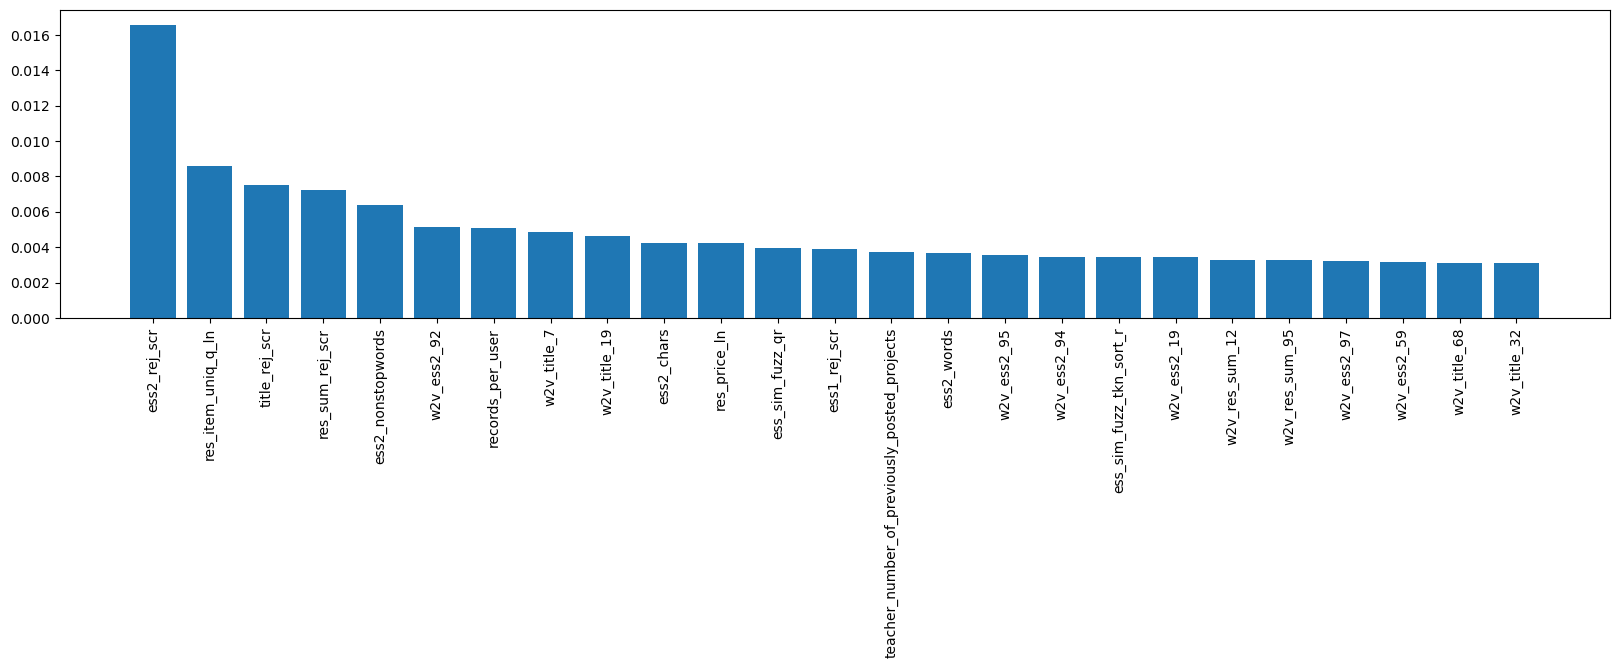

In [18]:
xgbc13 = xgb.XGBClassifier(objective= 'binary:logistic', 
                           n_estimators= 400, 
                           max_depth= 4, 
                           learning_rate= 0.1, 
                           gamma= 0.75, 
                           subsample= 0.9, 
                           colsample_bytree= 0.9, 
                           random_state=42)


iter13_metrics_arr = get_classification_report(model=xgbc13, 
                                               df_train=X3_train, 
                                               X_train=X3_train_scl, 
                                               y_train=y3_train, 
                                               X_test=X3_test_scl, 
                                               y_test=y3_test)

## **XGB Classifier (Balanced Target)**

In [19]:
y3_train.value_counts()

1    26004
0     4584
Name: project_is_approved, dtype: int64

In [20]:
X3_train_scl_smote, y3_train_smote = balance_target(X_train_scl=X3_train_scl, 
                                                    y_train=y3_train)

In [21]:
y3_train_smote.value_counts()

1    26004
0    26004
Name: project_is_approved, dtype: int64

In [22]:
# parameters = {
#     "n_estimators":[100, 200, 300, 400, 500],
#     "learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4],
#     "gamma": [0, 0.25, 0.5, 0.75, 1, 1.5, 2],
#     "max_depth":[2, 4, 6, 8],
#     'subsample': [0.3, 0.5, 0.7, 0.9],
#     "colsample_bytree" : [0.3, 0.5, 0.7, 0.9],
#     "objective" : ['binary:logistic']
#     # "eval_metric" : ['auc']

# }



# xgbc = xgb.XGBClassifier()

# # grid_search2 = GridSearchCV(
# #     estimator = xgbc,
# #     param_grid = parameters,
# #     scoring = "accuracy",
# #     n_jobs = -1,
# #     refit=True,               
# #     cv=3,
# #     verbose=1
# #     # return_train_score=False
# # )

# rand_search2 = RandomizedSearchCV(
#     estimator = xgbc,
#     param_distributions = parameters,
#     n_iter=200,
#     scoring = "accuracy",
#     n_jobs = -1,
#     refit=True,               
#     cv=3,
#     verbose=1
#     # return_train_score=False
# )


# start_time = time.time()
# # grid_search2.fit(X3_train_scl_smote, y3_train_smote)
# rand_search2.fit(X3_train_scl_smote, y3_train_smote)
# end_time = time.time()

# print(end_time-start_time)

In [23]:
# Fitting 3 folds for each of 200 candidates, totalling 600 fits: 1532.6440649032593


# {'subsample': 0.9,
#  'objective': 'binary:logistic',
#  'n_estimators': 300,
#  'max_depth': 8,
#  'learning_rate': 0.1,
#  'gamma': 0.25,
#  'colsample_bytree': 0.5}

# rand_search2.best_params_

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:XGBClassifier
----------------------------------------------------------------------
Train accuracy: 1.0
Test accuracy: 0.8463768115942029
ROC-AUC score:  0.7262036162765306
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.49      0.15      0.22      2006
           1       0.86      0.97      0.91     11104

    accuracy                           0.85     13110
   macro avg       0.68      0.56      0.57     13110
weighted avg       0.81      0.85      0.81     13110

--------------------------------------------------
Confusion Matrix on Test Set:
[[  292  1714]
 [  300 10804]]
--------------------------------------------------
Top-10 important features:
records_per_user_cat      0.101526
teacher_prefix            0.037878
res_item_uniq_q_ln        0.037014
Literacy                  0.

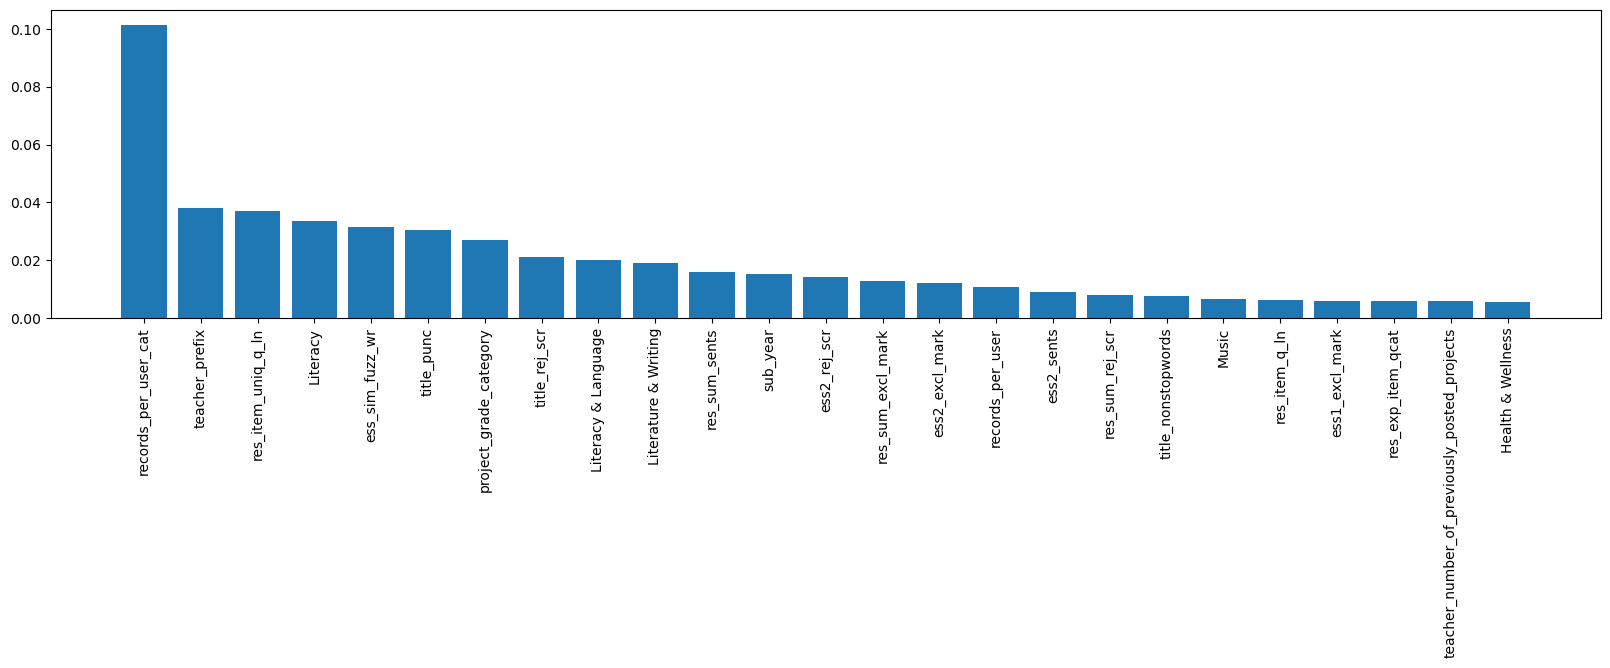

In [24]:
xgbc14 = xgb.XGBClassifier(objective= 'binary:logistic', 
                           n_estimators= 300, 
                           max_depth= 8, 
                           learning_rate= 0.1, 
                           gamma= 0.25, 
                           subsample= 0.9, 
                           colsample_bytree= 0.5, 
                           random_state=42)


iter14_metrics_arr = get_classification_report(model=xgbc14, 
                                               df_train=X3_train, 
                                               X_train=X3_train_scl_smote, 
                                               y_train=y3_train_smote, 
                                               X_test=X3_test_scl, 
                                               y_test=y3_test)

# **Training on the entire dataset**

In [24]:
X4_train, y4_train, X4_test, y4_test, X4_train_scl, X4_test_scl = preprocess_pipe(train_final_df, 
                                                                                  test_final_df)

Train shape: (76471, 518) (76471,)
Test shape: (32774, 518) (32774,)
--------------------------------------------------
Pre Cat2Num Transformation
Categorical columns length: 5
Numerical columns length: 513
Other columns length: 0
--------------------------------------------------
Post Cat2Num Transformation
Categorical columns length: 0
Numerical columns length: 518
Other columns length: 0
--------------------------------------------------
Feature Scaling Done
Categorical columns length: 0
Numerical columns length: 518
Other columns length: 0
--------------------------------------------------


## **XGB Classifier (Imbalanced target)**

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:XGBClassifier
----------------------------------------------------------------------
Train accuracy: 0.9029174458291378
Test accuracy: 0.8456703484469397
ROC-AUC score:  0.7414089840307072
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.16      0.24      5050
           1       0.86      0.97      0.91     27724

    accuracy                           0.85     32774
   macro avg       0.68      0.56      0.58     32774
weighted avg       0.81      0.85      0.81     32774

--------------------------------------------------
Confusion Matrix on Test Set:
[[  797  4253]
 [  805 26919]]
--------------------------------------------------
Top-10 important features:
ess2_rej_scr                                    0.025434
title_rej_scr                                   0.011301
res_

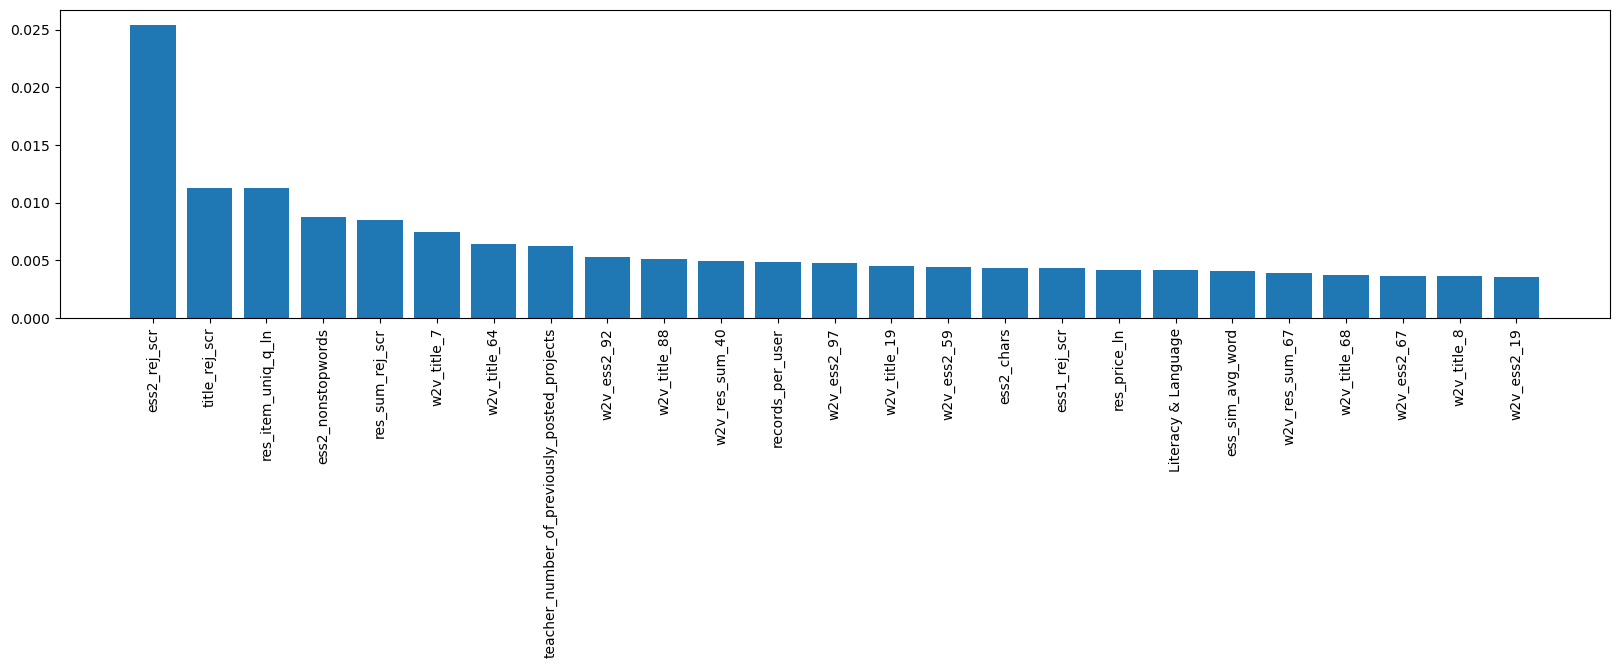

In [26]:
xgbc15 = xgb.XGBClassifier(objective= 'binary:logistic', 
                           n_estimators= 400, 
                           max_depth= 4, 
                           learning_rate= 0.1, 
                           gamma= 0.75, 
                           subsample= 0.9, 
                           colsample_bytree= 0.9, 
                           random_state=42)


iter15_metrics_arr = get_classification_report(model=xgbc15, 
                                               df_train=X4_train, 
                                               X_train=X4_train_scl, 
                                               y_train=y4_train, 
                                               X_test=X4_test_scl, 
                                               y_test=y4_test)

## **XGB Classifier (Balanced target)**

In [27]:
y4_train.value_counts()

1    64979
0    11492
Name: project_is_approved, dtype: int64

In [28]:
X4_train_scl_smote, y4_train_smote = balance_target(X_train_scl=X4_train_scl, 
                                                    y_train=y4_train)

In [29]:
y4_train_smote.value_counts()

1    64979
0    64979
Name: project_is_approved, dtype: int64

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:XGBClassifier
----------------------------------------------------------------------
Train accuracy: 0.9980301328121393
Test accuracy: 0.8470433880515043
ROC-AUC score:  0.731042150276202
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.17      0.26      5050
           1       0.87      0.97      0.91     27724

    accuracy                           0.85     32774
   macro avg       0.69      0.57      0.59     32774
weighted avg       0.81      0.85      0.81     32774

--------------------------------------------------
Confusion Matrix on Test Set:
[[  874  4176]
 [  837 26887]]
--------------------------------------------------
Top-10 important features:
records_per_user_cat      0.121303
res_item_uniq_q_ln        0.048403
teacher_prefix            0.043258
ess_sim_fuzz_w

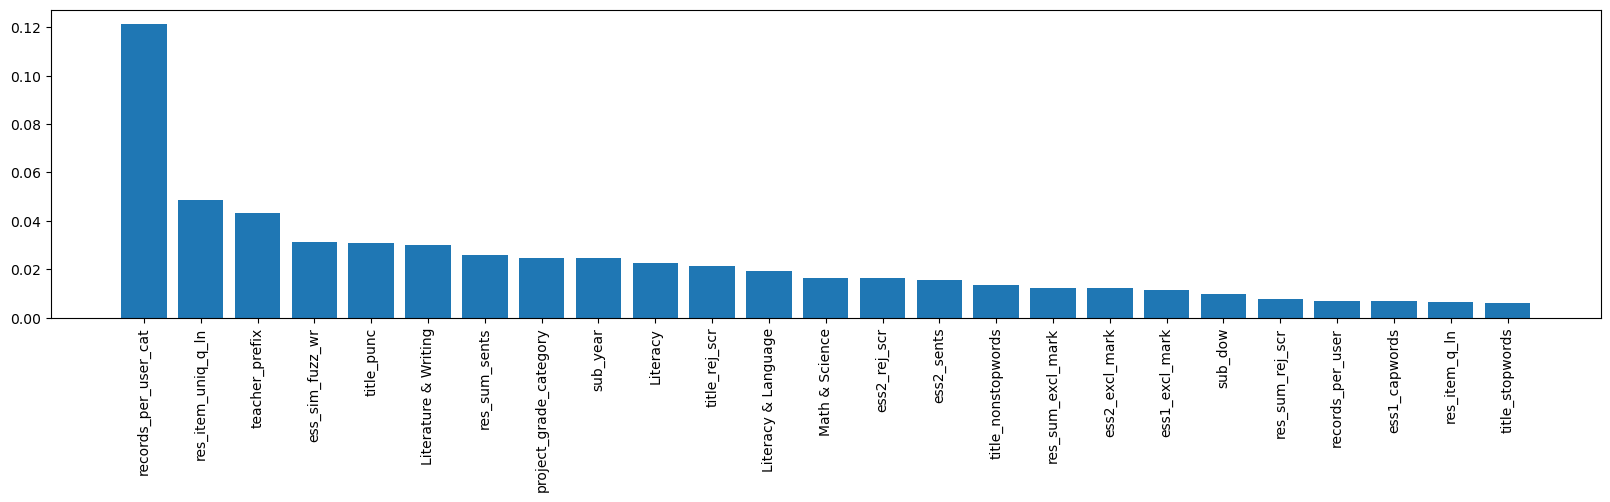

In [30]:
xgbc16 = xgb.XGBClassifier(objective= 'binary:logistic', 
                           n_estimators= 300, 
                           max_depth= 8, 
                           learning_rate= 0.1, 
                           gamma= 0.25, 
                           subsample= 0.9, 
                           colsample_bytree= 0.5, 
                           random_state=42)


iter16_metrics_arr = get_classification_report(model=xgbc16, 
                                               df_train=X4_train, 
                                               X_train=X4_train_scl_smote, 
                                               y_train=y4_train_smote, 
                                               X_test=X4_test_scl, 
                                               y_test=y4_test)

# **Hyperparameter Tuning (Full Data)**

In [31]:
# parameters = {
#     "n_estimators":[100, 200, 300, 400, 500],
#     "learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4],
#     "gamma": [0, 0.25, 0.5, 0.75, 1, 1.5, 2],
#     "max_depth":[2, 4, 6, 8],
#     'subsample': [0.3, 0.5, 0.7, 0.9],
#     "colsample_bytree" : [0.3, 0.5, 0.7, 0.9],
#     "objective" : ['binary:logistic']
#     # "eval_metric" : ['auc']

# }



# xgbc = xgb.XGBClassifier()

# # grid_search3 = GridSearchCV(
# #     estimator = xgbc,
# #     param_grid = parameters,
# #     scoring = "accuracy",
# #     n_jobs = -1,
# #     refit=True,               
# #     cv=3,
# #     verbose=1
# #     # return_train_score=False
# # )

# rand_search3 = RandomizedSearchCV(
#     estimator = xgbc,
#     param_distributions = parameters,
#     n_iter=250,
#     scoring = "accuracy",
#     n_jobs = -1,
#     refit=True,               
#     cv=3,
#     verbose=1
#     # return_train_score=False
# )


# start_time = time.time()
# # grid_search3.fit(X4_train_scl, y4_train)
# rand_search3.fit(X4_train_scl, y4_train)
# end_time = time.time()

# print(end_time-start_time)

In [32]:
# Fitting 3 folds for each of 250 candidates, totalling 750 fits: 2685.8447370529175

# {'subsample': 0.7,
#  'objective': 'binary:logistic',
#  'n_estimators': 400,
#  'max_depth': 4,
#  'learning_rate': 0.1,
#  'gamma': 0.25,
#  'colsample_bytree': 0.5}


# rand_search3.best_params_

Fitting model completed!
----------------------------------------------------------------------
Classification Report: Model:XGBClassifier
----------------------------------------------------------------------
Train accuracy: 0.9007074577290738
Test accuracy: 0.8473485079636297
ROC-AUC score:  0.7420356348504566
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.17      0.25      5050
           1       0.86      0.97      0.91     27724

    accuracy                           0.85     32774
   macro avg       0.69      0.57      0.58     32774
weighted avg       0.81      0.85      0.81     32774

--------------------------------------------------
Confusion Matrix on Test Set:
[[  848  4202]
 [  801 26923]]
--------------------------------------------------
Top-10 important features:
ess2_rej_scr                                    0.019707
res_item_uniq_q_ln                              0.012640
titl

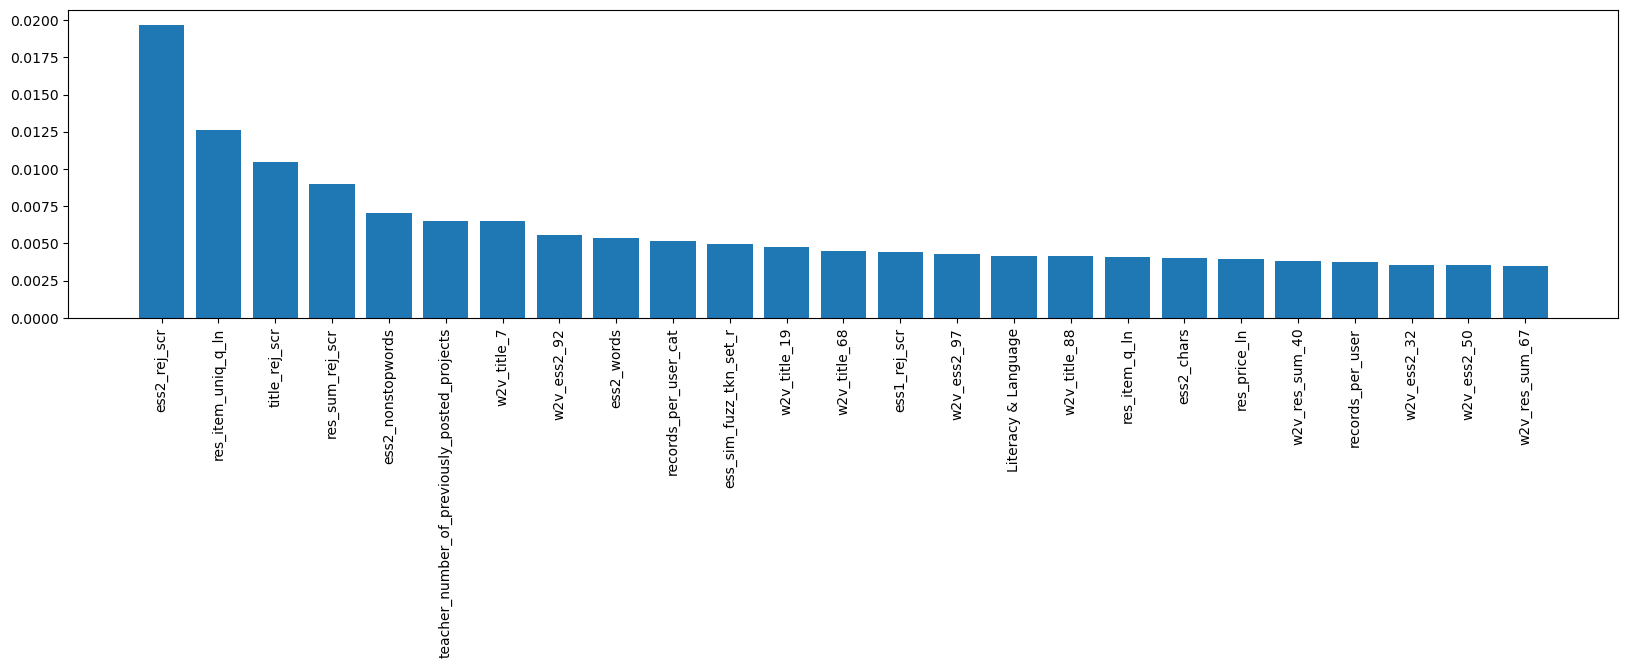

In [25]:
xgbc17 = xgb.XGBClassifier(objective= 'binary:logistic', 
                           n_estimators= 400, 
                           max_depth= 4, 
                           learning_rate= 0.1, 
                           gamma= 0.25, 
                           subsample= 0.7, 
                           colsample_bytree= 0.5, 
                           random_state=42)


iter17_metrics_arr = get_classification_report(model=xgbc17, 
                                               df_train=X4_train, 
                                               X_train=X4_train_scl, 
                                               y_train=y4_train, 
                                               X_test=X4_test_scl, 
                                               y_test=y4_test)

# **Model Comparison**

In [34]:
df_metrics = pd.DataFrame([iter13_metrics_arr, iter14_metrics_arr, iter15_metrics_arr, 
                           iter16_metrics_arr, iter17_metrics_arr],
                          columns= ['train_acc', 'test_acc', 'roc_auc', 'prec_0', 'rec_0', 'f1_0', 'prec_1', 'rec_1', 'f1_1'],
                          index=[i for i in range(13, 18)]
                         )



df_metrics['Model'] = ['XGB_Classifier']*5
df_metrics['Features'] = ['Metadata+BasicNLP+w2v']*5
df_metrics['Sample_Size(%)'] = [40]*2 + [100]*3
df_metrics['Balanced_Target'] = ['No', 'Yes']*2 + ['No']
df_metrics['Hyper_Tuned'] = ['Yes']*2 + ['No']*2 + ['Yes']


df1 = df_metrics.iloc[:, -5:] 
df2 = df_metrics.iloc[:, :-5]
df_metrics = pd.concat([df1, df2], axis=1)
df_metrics.reset_index(inplace=True)
df_metrics.rename({'index':'Iteration'}, axis=1, inplace=True)
df_metrics.iloc[:, :9]

,Iteration,Model,Features,Sample_Size(%),Balanced_Target,Hyper_Tuned,train_acc,test_acc,roc_auc
0,13,XGB_Classifier,Metadata+BasicNLP+w2v,40,No,Yes,0.937263,0.847063,0.729689
1,14,XGB_Classifier,Metadata+BasicNLP+w2v,40,Yes,Yes,1.000000,0.846377,0.726204
2,15,XGB_Classifier,Metadata+BasicNLP+w2v,100,No,No,0.902917,0.845670,0.741409
3,16,XGB_Classifier,Metadata+BasicNLP+w2v,100,Yes,No,0.998030,0.847043,0.731042
4,17,XGB_Classifier,Metadata+BasicNLP+w2v,100,No,Yes,0.900707,0.847349,0.742036


In [35]:
df_metrics_v1 = pd.read_csv('./model_evaluation/model_comparison_v1.csv')
df_metrics_v1

,Iteration,Model,Features,Sample_Size(%),Balanced_Target,Hyper_Tuned,train_acc,test_acc,roc_auc,prec_0,rec_0,f1_0,prec_1,rec_1,f1_1
0,1,RF_Classifier,Metadata,40,No,No,1.000000,0.845233,0.667922,0.311475,0.009472,0.018384,0.847728,0.996218,0.915994
1,2,XGB_Classifier,Metadata,40,No,No,0.883909,0.840046,0.668670,0.329588,0.043868,0.077431,0.850658,0.983880,0.912432
2,3,RF_Classifier,Metadata,40,Yes,No,1.000000,0.830892,0.661110,0.283368,0.068794,0.110710,0.852016,0.968570,0.906562
3,4,XGB_Classifier,Metadata,40,Yes,No,0.925723,0.841724,0.675150,0.345291,0.038385,0.069089,0.850314,0.986852,0.913509
4,5,RF_Classifier,Metadata+BasicNLP,40,No,No,1.000000,0.848970,0.714746,0.543624,0.080758,0.140625,0.856072,0.987752,0.917210
5,6,XGB_Classifier,Metadata+BasicNLP,40,No,No,0.944194,0.839588,0.710281,0.438059,0.170987,0.245966,0.865093,0.960375,0.910247
6,7,RF_Classifier,Metadata+BasicNLP,40,Yes,No,1.000000,0.834477,0.721063,0.423364,0.225823,0.294538,0.871013,0.944434,0.906239
7,8,XGB_Classifier,Metadata+BasicNLP,40,Yes,No,0.963467,0.838673,0.704976,0.434416,0.179960,0.254494,0.866031,0.957673,0.909550
8,9,RF_Classifier,Metadata+BasicNLP+w2v,40,No,No,1.000000,0.849352,0.702970,0.712329,0.025922,0.050024,0.850119,0.998109,0.918189
9,10,XGB_Classifier,Metadata+BasicNLP+w2v,40,No,No,0.994835,0.841419,0.716461,0.448664,0.159023,0.234818,0.863941,0.964697,0.911543


In [36]:
df_metrics_v2 = pd.concat([df_metrics_v1, df_metrics], axis=0).reset_index(drop=True)
df_metrics_v2.iloc[:, :9]

,Iteration,Model,Features,Sample_Size(%),Balanced_Target,Hyper_Tuned,train_acc,test_acc,roc_auc
0,1,RF_Classifier,Metadata,40,No,No,1.000000,0.845233,0.667922
1,2,XGB_Classifier,Metadata,40,No,No,0.883909,0.840046,0.668670
2,3,RF_Classifier,Metadata,40,Yes,No,1.000000,0.830892,0.661110
3,4,XGB_Classifier,Metadata,40,Yes,No,0.925723,0.841724,0.675150
4,5,RF_Classifier,Metadata+BasicNLP,40,No,No,1.000000,0.848970,0.714746
5,6,XGB_Classifier,Metadata+BasicNLP,40,No,No,0.944194,0.839588,0.710281
6,7,RF_Classifier,Metadata+BasicNLP,40,Yes,No,1.000000,0.834477,0.721063
7,8,XGB_Classifier,Metadata+BasicNLP,40,Yes,No,0.963467,0.838673,0.704976
8,9,RF_Classifier,Metadata+BasicNLP+w2v,40,No,No,1.000000,0.849352,0.702970
9,10,XGB_Classifier,Metadata+BasicNLP+w2v,40,No,No,0.994835,0.841419,0.716461


In [37]:
# df_metrics_v2.to_csv('./model_evaluation/model_comparison_v2.csv', sep=',', index=False)

# **Selecting sample inputs**

In [39]:
test_final_df.head()

,id,project_is_approved,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,sub_year,sub_month,sub_dow,sub_hour,...,w2v_res_sum_92,w2v_res_sum_93,w2v_res_sum_94,w2v_res_sum_95,w2v_res_sum_96,w2v_res_sum_97,w2v_res_sum_98,w2v_res_sum_99,res_sum_skew,res_sum_kurt
0,p142530,1,Mrs.,CT,Grades PreK-2,202,2017,3,5,14,...,0.136592,-0.648919,0.225220,0.242977,0.388824,0.328295,0.906361,0.319578,-0.114347,-0.170247
1,p178341,1,Mrs.,MT,Grades 9-12,0,2016,5,3,15,...,-0.287339,-0.213949,0.500258,-0.213436,-0.064430,0.570470,0.347020,0.467722,-0.449589,0.226416
2,p181429,1,Mrs.,ME,Grades PreK-2,4,2016,4,2,11,...,-0.311275,0.284607,0.784916,0.204847,0.763133,0.311461,-0.041367,-0.942613,-0.205458,0.413540
3,p207487,1,Mrs.,TX,Grades PreK-2,7,2016,10,2,7,...,-0.684237,-0.251121,-0.438203,-0.480700,0.618055,-0.197718,-0.095292,0.012018,-0.059548,0.827443
4,p119115,1,Mrs.,CO,Grades 6-8,0,2017,3,3,11,...,-0.707539,0.042248,0.112278,-0.290206,0.529188,-0.371929,0.420826,-0.162720,-0.341949,1.078719


In [40]:
np.unique(xgbc17.predict(X4_test_scl), return_counts=True)

(array([0, 1]), array([ 1649, 31125]))

In [41]:
xgbc17.predict_proba(X4_test_scl)

array([[0.02982819, 0.9701718 ],
       [0.02013338, 0.9798666 ],
       [0.01539129, 0.9846087 ],
       ...,
       [0.10187566, 0.89812434],
       [0.0288825 , 0.9711175 ],
       [0.02084279, 0.9791572 ]], dtype=float32)

In [42]:
y4_pred_proba = xgbc17.predict_proba(X4_test_scl)[:, 1]
y4_pred_proba

array([0.9701718 , 0.9798666 , 0.9846087 , ..., 0.89812434, 0.9711175 ,
       0.9791572 ], dtype=float32)

In [43]:
def get_idx(bool_arr):
    idx_lst = []
    for i, val in enumerate(bool_arr):
        if val==True:
            idx_lst.append(i)
    return idx_lst

In [44]:
mask_rej = y4_pred_proba<0.4
mask_mod = (y4_pred_proba>=0.51) & (y4_pred_proba<0.7)
mask_acp = (y4_pred_proba>=0.85) & (y4_pred_proba<0.95)

print(len(y4_pred_proba))
print('-'*50)
print(len(y4_pred_proba[mask_rej]))
print(len(y4_pred_proba[mask_mod]))
print(len(y4_pred_proba[mask_acp]))
print('-'*80)

pids_rej = test_final_df.iloc[get_idx(mask_rej)].id
pids_mod = test_final_df.iloc[get_idx(mask_mod)].id
pids_acp = test_final_df.iloc[get_idx(mask_acp)].id

print(len(pids_rej))
print(len(pids_mod))
print(len(pids_acp))

32774
--------------------------------------------------
916
2724
11414
--------------------------------------------------------------------------------
916
2724
11414


## **Loading main dataframe**

In [45]:
df_proj_org = pd.read_csv('./data/train_data.csv')
df_proj_org['dos'] = pd.to_datetime(df_proj_org['project_submitted_datetime']).dt.date.astype('str')
df_proj_org_filt1 = df_proj_org.loc[df_proj_org['dos']>'2016-05-17'].copy()
df_proj_org_filt2 = df_proj_org_filt1.loc[df_proj_org_filt1['school_state'].isin(['CA', 'TX', 'NY', 'FL', 'NC', 'IL', 'GA', 'SC', 'MI', 'PA'])]

print(df_proj_org.shape)
print(df_proj_org_filt1.shape)
print(df_proj_org_filt2.shape)

(109248, 18)
(105327, 18)
(57924, 18)


In [46]:
df_res_org = pd.read_csv('./data/resources.csv')
df_res_org_filt2 = df_res_org.loc[df_res_org['id'].isin(df_proj_org_filt2.id)].copy()

print(df_res_org.shape)
print(df_res_org_filt2.shape)

(1541272, 4)
(344493, 4)


In [47]:
df_proj_org.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'dos'],
      dtype='object')

In [48]:
cols_of_interest = ['id', 'teacher_prefix', 'school_state', 'project_grade_category', 'project_subject_categories',                                             
                    'project_title', 'project_essay_1', 'project_essay_2', 'project_resource_summary',                                      
                    'project_is_approved']

In [49]:
rej_examples = df_proj_org_filt2.loc[df_proj_org_filt2['id'].isin(pids_rej), cols_of_interest].copy()
mod_examples = df_proj_org_filt2.loc[df_proj_org_filt2['id'].isin(pids_mod), cols_of_interest].copy()
acc_examples = df_proj_org_filt2.loc[df_proj_org_filt2['id'].isin(pids_acp), cols_of_interest].copy()

In [50]:
print('Rejected Examples:', rej_examples.shape)
print('Moderate Examples:', mod_examples.shape)
print('Accepted Examples:', acc_examples.shape)

Rejected Examples: (486, 10)
Moderate Examples: (1459, 10)
Accepted Examples: (5987, 10)


In [51]:
def merge_proj_and_res(df, df_res):
    
    df_res_agg = df_res.groupby('id')['price'].count().reset_index()
    df_merge = pd.merge(df, df_res_agg, on='id', how='inner')
    df_merge.rename({'price': 'res_count'}, axis=1, inplace=True)
    return df_merge

## **Rejected Submissions**

In [52]:
rej_examples.head()

,id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_title,project_essay_1,project_essay_2,project_resource_summary,project_is_approved
373,p174270,Ms.,CA,Grades PreK-2,"Literacy & Language, Math & Science",1st Grade Wise Owls,My students are eager to learn and engage in s...,My students come from a tough neighborhood in ...,My students need supplies that encourage and s...,0
481,p004008,Mrs.,PA,Grades PreK-2,"Literacy & Language, Math & Science",Making Students Centered On Learning,My first grade is comprised of 20 amazing stud...,My first graders are passionate about learning...,My students need math and literacy centers to ...,1
674,p214175,Mrs.,CA,Grades PreK-2,Math & Science,STEM Kits for Maker Space,Students in every grade level of our school re...,Our school is a STEM Magnet TK - 8th grade. A...,My students need STEM learning kits to explore...,0
823,p161877,Teacher,CA,Grades PreK-2,"Applied Learning, Math & Science","Materials For Our \""Learning Centers\"" Sound L...","They reside within a dilapidated, impoverished...",Many of my students' current supply necessitie...,My students need a computer to take in knowled...,0
994,p123638,Ms.,CA,Grades 9-12,Special Needs,Growing Garden,"As a special education teacher, I strive to cr...",Our garden provides an environment for social ...,"My students need shovels,pots, ground cover, a...",1


In [53]:
rej_examples_res_agg = merge_proj_and_res(rej_examples, df_res_org_filt2)
print(rej_examples_res_agg['res_count'].value_counts().sort_index().iloc[:5])

1    11
2     8
3    17
4    36
5    42
Name: res_count, dtype: int64


In [54]:
rej_examples_res_agg_cnt1 = rej_examples_res_agg.loc[rej_examples_res_agg['res_count']==1]
rej_examples_res_agg_cnt1.shape

(11, 11)

In [55]:
test_ser = rej_examples_res_agg_cnt1.iloc[1]
for indx in test_ser.index[:-2]:
    print(f'{indx}: {test_ser.loc[indx]}')
    print('-'*50)

print('~'*80)
print('RESOURCES')
print('~'*80)

test_df_res = df_res_org_filt2.loc[df_res_org_filt2['id']==test_ser.loc['id'], ['description', 'quantity', 'price']]
for i in range(len(test_df_res)):
    for indx in test_df_res.iloc[i].index:
        print(f'{indx}: {test_df_res.iloc[i].loc[indx]}')
        print('-'*50)

id: p135754
--------------------------------------------------
teacher_prefix: Ms.
--------------------------------------------------
school_state: MI
--------------------------------------------------
project_grade_category: Grades 3-5
--------------------------------------------------
project_subject_categories: Health & Sports
--------------------------------------------------
project_title: Student Inspired Garden to Teach for the Planet
--------------------------------------------------
project_essay_1: My student's are ready and excited to learn even though many of them do not have the opportunities that many other children might have.  I am sure if they are allowed to participate in this project that they will carry over this new learn knowledge to their everyday life.    \r\nSo many of our students are struggling with their finances at home just to get through each day and they don't have opportunities or funds to participate in using technology. \r\nOur school serves a very di

## **Moderate Submissions**

In [56]:
mod_examples.head()

,id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_title,project_essay_1,project_essay_2,project_resource_summary,project_is_approved
105,p184043,Mr.,IL,Grades 3-5,Music & The Arts,Ceramics: Our History in Clay and Sculpture,Our school is a diverse school from different ...,This project is about starting a ceramics prog...,My students need the safety and basic equipmen...,0
224,p165749,Mrs.,NY,Grades 3-5,Math & Science,SCIENCE FOR SUCCESS!!!,My students are a wonderful group of children....,\r\n\r\nMy students are a wonderful group of c...,My students need an iPad mini to help develop ...,1
371,p073979,Ms.,CA,Grades 6-8,Literacy & Language,"Today a Reader, Tomorrow a Leader","Our middle school students are readers, writer...","“Today a reader, tomorrow a leader.” – Margare...","My students need books, books, and more books ...",1
537,p135741,Ms.,SC,Grades PreK-2,Math & Science,Hands on Math and Science tools for SUPERhero ...,I have a class full of 20 eager students! All...,My students will thrive with these materials!!...,My students need all of the following items to...,0
615,p117637,Mrs.,TX,Grades 3-5,Literacy & Language,Library LACKING Literacy,Most of the students I serve come from a low i...,In a school where many students struggle with ...,My students need literacy tools to build readi...,1


In [57]:
mod_examples_res_agg = merge_proj_and_res(mod_examples, df_res_org_filt2)
print(mod_examples_res_agg['res_count'].value_counts().sort_index().iloc[:5])

1     72
2    115
3    137
4    171
5    139
Name: res_count, dtype: int64


In [58]:
mod_examples_res_agg_cnt1 = mod_examples_res_agg.loc[mod_examples_res_agg['res_count']==1]
mod_examples_res_agg_cnt1.shape

(72, 11)

In [81]:
test_ser = mod_examples_res_agg_cnt1.iloc[0]
for indx in test_ser.index[:-2]:
    print(f'{indx}: {test_ser.loc[indx]}')
    print('-'*50)

print('~'*80)
print('RESOURCES')
print('~'*80)

test_df_res = df_res_org_filt2.loc[df_res_org_filt2['id']==test_ser.loc['id'], ['description', 'quantity', 'price']]
for i in range(len(test_df_res)):
    for indx in test_df_res.iloc[i].index:
        print(f'{indx}: {test_df_res.iloc[i].loc[indx]}')
        print('-'*50)

id: p165749
--------------------------------------------------
teacher_prefix: Mrs.
--------------------------------------------------
school_state: NY
--------------------------------------------------
project_grade_category: Grades 3-5
--------------------------------------------------
project_subject_categories: Math & Science
--------------------------------------------------
project_title: SCIENCE FOR SUCCESS!!!
--------------------------------------------------
project_essay_1: My students are a wonderful group of children. They love coming to school each and every day. They work hard in all academic areas. They are struggling learners who put forth a tremendous amount of effort to excel.\r\n\r\nMy students are wonderful and they love to learn! They try so hard all day long, and have made such amazing improvements this year and would love to continue to make improvements. They look forward to school each and every day and every subject is exciting for them.
----------------------

## **Accepted Submissions**

In [60]:
acc_examples.head()

,id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_title,project_essay_1,project_essay_2,project_resource_summary,project_is_approved
67,p004129,Ms.,FL,Grades 3-5,Literacy & Language,The Magic of Reading,My students struggle with emotional and learni...,My students struggle in most academic areas sp...,My students need books to enhance our class l...,1
78,p109123,Mrs.,SC,Grades 6-8,Math & Science,Stand-Up Desks for Mrs. Brown's Class,I have a 115 middle school students ages 11-14...,My 7th grade students come to class with lots ...,My students need stand up desks to keep the ac...,1
79,p138448,Ms.,TX,Grades 3-5,Music & The Arts,"Make Music, Make Our Year!",Though many schools like to highlight the dive...,Our new K-6 music program has few supplies but...,"My students need Orff instruments, guitars, an...",0
87,p206972,Ms.,IL,Grades 6-8,"Literacy & Language, Special Needs",Exploring Graphic Novels,My students are middle school students from a ...,My students struggle to enjoy reading. They t...,My students need assorted high-interest graphi...,1
103,p019188,Mr.,GA,Grades 9-12,Music & The Arts,Buzzing With Books,"\""Help us to be the best band that we can be.\...",The Foundations for Superior Performance metho...,My students need books made to help them perfe...,1


In [61]:
acc_examples_res_agg = merge_proj_and_res(acc_examples, df_res_org_filt2)
print(acc_examples_res_agg['res_count'].value_counts().sort_index().iloc[:5])

1    1460
2    1069
3     797
4     521
5     372
Name: res_count, dtype: int64


In [62]:
acc_examples_res_agg_cnt1 = acc_examples_res_agg.loc[acc_examples_res_agg['res_count']==1]
acc_examples_res_agg_cnt1.shape

(1460, 11)

In [82]:
test_ser = acc_examples_res_agg_cnt1.iloc[0]
for indx in test_ser.index[:-2]:
    print(f'{indx}: {test_ser.loc[indx]}')
    print('-'*50)

print('~'*80)
print('RESOURCES')
print('~'*80)

test_df_res = df_res_org_filt2.loc[df_res_org_filt2['id']==test_ser.loc['id'], ['description', 'quantity', 'price']]
for i in range(len(test_df_res)):
    for indx in test_df_res.iloc[i].index:
        print(f'{indx}: {test_df_res.iloc[i].loc[indx]}')
        print('-'*50)

id: p109123
--------------------------------------------------
teacher_prefix: Mrs.
--------------------------------------------------
school_state: SC
--------------------------------------------------
project_grade_category: Grades 6-8
--------------------------------------------------
project_subject_categories: Math & Science
--------------------------------------------------
project_title: Stand-Up Desks for Mrs. Brown's Class
--------------------------------------------------
project_essay_1: I have a 115 middle school students ages 11-14. Many of my students come to class ready to learn, but sometimes lack the supplies necessary. It is not unusual to lend out pencils, paper, and calculators to my students.  What they lack in supplies that make up in with personality. \r\n\r\nMany of my students have big aspirations for the future. I want to create a learning environment that allows all students to work hard and make these dreams come true.  Setting up projects through Donors Cho

In [92]:
df_proj_org.loc[df_proj_org['id']=='p049008'].iloc[:, 1:]

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,dos
135,p049008,65a6491585f0307afcfe23e0bda1707b,Mr.,TX,2016-12-10 20:39:04,Grades PreK-2,Music & The Arts,Visual Arts,Art in the 21st Century,Despite being a Title I school and having a la...,It is important for my students to not only le...,NaN,NaN,My students need ipad minis to upload and emai...,5,1,2016-12-10


In [93]:
# df_proj_org.loc[df_proj_org['id']=='p049008'].iloc[0]

In [88]:
df_res_org.loc[df_res_org['id']=='p049008']

,id,description,quantity,price
1061699,p049008,Apple - iPad mini 4 Wi-Fi 128GB - Space Gray,2,509.72
1061700,p049008,Targus - VersaVu Slim Case for Apple� iPad� mi...,2,25.35


# **Prediction Debug**

In [64]:
df_proj_org.loc[df_proj_org.id=='p092944']

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,dos
1380,103020,p092944,87bc1584ca9d5bfe79365c5427a0bc14,Ms.,PA,2017-04-12 12:17:22,Grades 9-12,Health & Sports,Team Sports,Foam Hockey Stick Blades for Safety,My school district encompasses 50 square miles...,Our physical education students need to replac...,NaN,NaN,My students need to cover their plastic hockey...,1,1,2017-04-12


In [65]:
# Teacher ID has only 1 sample
df_proj_org.loc[df_proj_org['teacher_id']=='87bc1584ca9d5bfe79365c5427a0bc14']

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,dos
1380,103020,p092944,87bc1584ca9d5bfe79365c5427a0bc14,Ms.,PA,2017-04-12 12:17:22,Grades 9-12,Health & Sports,Team Sports,Foam Hockey Stick Blades for Safety,My school district encompasses 50 square miles...,Our physical education students need to replac...,NaN,NaN,My students need to cover their plastic hockey...,1,1,2017-04-12


In [66]:
test_final_df.loc[test_final_df['id']=='p092944']

,id,project_is_approved,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,sub_year,sub_month,sub_dow,sub_hour,...,w2v_res_sum_92,w2v_res_sum_93,w2v_res_sum_94,w2v_res_sum_95,w2v_res_sum_96,w2v_res_sum_97,w2v_res_sum_98,w2v_res_sum_99,res_sum_skew,res_sum_kurt
28748,p092944,1,Ms.,PA,Grades 9-12,1,2017,4,2,12,...,-0.520733,0.160593,0.375971,0.410386,0.061733,-0.103647,-0.390809,-0.083117,0.01515,-0.274784


In [67]:
_, _, X100_test, y100_test, _, X100_test_scl = preprocess_pipe(train_final_df, 
                                                               test_final_df.loc[test_final_df['id']=='p092944'])

Train shape: (76471, 518) (76471,)
Test shape: (1, 518) (1,)
--------------------------------------------------
Pre Cat2Num Transformation
Categorical columns length: 5
Numerical columns length: 513
Other columns length: 0
--------------------------------------------------
Post Cat2Num Transformation
Categorical columns length: 0
Numerical columns length: 518
Other columns length: 0
--------------------------------------------------
Feature Scaling Done
Categorical columns length: 0
Numerical columns length: 518
Other columns length: 0
--------------------------------------------------


In [68]:
xgbc17.predict(X100_test_scl)

array([1])

In [69]:
xgbc17.predict_proba(X100_test_scl)

array([[0.00267434, 0.99732566]], dtype=float32)

## **Debug Post FE**

In [70]:
trainpipe_df = test_final_df.loc[test_final_df['id']=='p092944']
trainpipe_df

,id,project_is_approved,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,sub_year,sub_month,sub_dow,sub_hour,...,w2v_res_sum_92,w2v_res_sum_93,w2v_res_sum_94,w2v_res_sum_95,w2v_res_sum_96,w2v_res_sum_97,w2v_res_sum_98,w2v_res_sum_99,res_sum_skew,res_sum_kurt
28748,p092944,1,Ms.,PA,Grades 9-12,1,2017,4,2,12,...,-0.520733,0.160593,0.375971,0.410386,0.061733,-0.103647,-0.390809,-0.083117,0.01515,-0.274784


In [71]:
predictpipe_df = pd.read_csv('./predict_debug/predict_fe.csv')
predictpipe_df

,id,project_is_approved,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,sub_year,sub_month,sub_dow,sub_hour,...,w2v_res_sum_92,w2v_res_sum_93,w2v_res_sum_94,w2v_res_sum_95,w2v_res_sum_96,w2v_res_sum_97,w2v_res_sum_98,w2v_res_sum_99,res_sum_skew,res_sum_kurt
0,p092944,1,Ms.,PA,Grades 9-12,1,2017,4,2,12,...,-0.520733,0.160593,0.375971,0.410386,0.061733,-0.103647,-0.390809,-0.083117,0.01515,-0.274784


In [72]:
def df_to_dict(df, index):
    pipe_dict = df.to_dict()
    for key in pipe_dict:
        pipe_dict[key] = pipe_dict[key][index]
    
    return pipe_dict

In [73]:
trainpipe_dict = df_to_dict(trainpipe_df, 28748)
# trainpipe_dict

In [74]:
predictpipe_dict = df_to_dict(predictpipe_df, 0)
# predictpipe_dict

In [75]:
# Checking mismatch in keys:
key_mismatch = 0
for key in predictpipe_dict:
    if key not in trainpipe_dict:
        key_mismatch += 1
        print(f'Key {key} present in predictpipe_dict but not in trainpipe_dict')
        
for key in trainpipe_dict:
    if key not in predictpipe_dict:
        key_mismatch += 1
        print(f'Key {key} present in trainpipe_dict but not in predictpipe_dict')

print('Total key Mismatch:', key_mismatch)

Total key Mismatch: 0


In [76]:
# Checking mismatch in values:

val_mismatch = 0
for key in predictpipe_dict:
    if predictpipe_dict[key]!=trainpipe_dict[key]:
        val_mismatch += 1
        # print(f'Key: {key}, Predict_Val: {predictpipe_dict[key]}, Train_val: {trainpipe_dict[key]}')
        # print('-'*50)

print('Total value Mismatch:', val_mismatch)

Total value Mismatch: 102


## **Debug Post Cat2Num**

In [77]:
_, _, X_test_trainpipe_c2n, y_test_trainpipe_c2n, _, X_test_scl_trainpipe_c2n = preprocess_pipe(train_final_df, 
                                                                                                test_final_df.loc[test_final_df['id']=='p092944'])

Train shape: (76471, 518) (76471,)
Test shape: (1, 518) (1,)
--------------------------------------------------
Pre Cat2Num Transformation
Categorical columns length: 5
Numerical columns length: 513
Other columns length: 0
--------------------------------------------------
Post Cat2Num Transformation
Categorical columns length: 0
Numerical columns length: 518
Other columns length: 0
--------------------------------------------------
Feature Scaling Done
Categorical columns length: 0
Numerical columns length: 518
Other columns length: 0
--------------------------------------------------


In [78]:
X_test_trainpipe_c2n

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,sub_year,sub_month,sub_dow,sub_hour,records_per_user,records_per_user_cat,...,w2v_res_sum_92,w2v_res_sum_93,w2v_res_sum_94,w2v_res_sum_95,w2v_res_sum_96,w2v_res_sum_97,w2v_res_sum_98,w2v_res_sum_99,res_sum_skew,res_sum_kurt
28748,0.843821,0.856681,0.840021,1,2017,4,2,12,1,1,...,-0.520733,0.160593,0.375971,0.410386,0.061733,-0.103647,-0.390809,-0.083117,0.01515,-0.274784


In [79]:
X_test_predictpipe_c2n = pd.read_csv('./predict_debug/predict_cat2num.csv')
X_test_predictpipe_c2n

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,sub_year,sub_month,sub_dow,sub_hour,records_per_user,records_per_user_cat,...,w2v_res_sum_92,w2v_res_sum_93,w2v_res_sum_94,w2v_res_sum_95,w2v_res_sum_96,w2v_res_sum_97,w2v_res_sum_98,w2v_res_sum_99,res_sum_skew,res_sum_kurt
0,0.843821,0.856681,0.840021,1,2017,4,2,12,1,1,...,-0.520733,0.160593,0.375971,0.410386,0.061733,-0.103647,-0.390809,-0.083117,0.01515,-0.274784


## **Post Feature Scaling**

In [80]:
# Error: model.predict(Unscaled_feature)
# Correction: model.predict(scaled_feature)